# DeepInsight SqueezeNet Example

This example shows a case of using the output of 
pyDeepInsight.ImageTransformer to train a SqueezeNet model
using PyTorch. This follows the general approach used in the
original DeepInsight paper.

## DeepInsight

In [3]:
from pyDeepInsight import ImageTransformer
from pyDeepInsight.utils import Norm2Scaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.manifold import TSNE
# from sklearn.decomposition import NMF
# import umap.umap_ as umap
import pandas as pd
import numpy as np
import pyreadr


## Training TSNE

Load example TCGA data and split into training and testing sets

In [23]:
chrr = "1"
result = pyreadr.read_r('../../Geno/SNPchrs/SNPchr'+ chrr+ '.RData')
# print(result.keys())
geno_chr = result["geno_chr"]

In [16]:
expr = geno_chr
y = expr.index
X = expr.values
X_train = X_test = X
ln = Norm2Scaler()
X_train_norm = ln.fit_transform(X_train)


In [17]:
# X_test_norm = ln.transform(X_test)
# Create t-SNE object
distance_metric = 'cosine'
reducer = TSNE(
    n_components=2,
    metric=distance_metric,
    init='random',
    learning_rate='auto',
    n_jobs=-1,
    random_state=42
)


d:\miniconda\envs\DL4Met\lib\site-packages\pyDeepInsight\image_transformer.py:270: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(x_new[:, 0], x_new[:, 1], s=1,


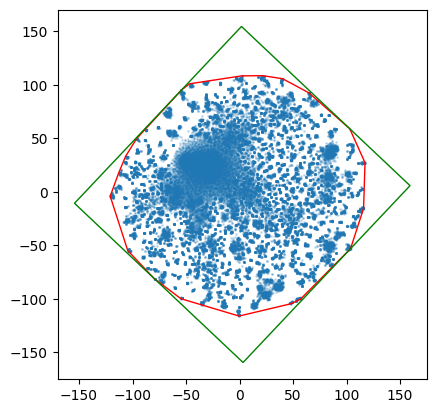

In [18]:
resolution = 277
# Initialize image transformer.
pixel_size = (resolution,resolution)
it = ImageTransformer(
    feature_extractor=reducer, 
    pixels=pixel_size)

# Train image transformer on training data and transform training 
# and testing sets. Values should be between 0 and 1.
it.fit(X_train, plot=True)


In [24]:
X_train_img = it.transform(X_train_norm, empty_value=1)
# X_test_img = it.transform(X_test_norm, empty_value=1)
np.save(f'../../SNPimg/Chr{chrr}_tsne_{resolution}.npy', X_train_img)

The feature density matrix can be extracted from the trained transformer in order to view overall feature overlap.

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

fdm = it.feature_density_matrix()
fdm[fdm == 0] = np.nan

plt.figure(figsize=(10, 7.5))

ax = sns.heatmap(fdm, cmap="viridis", linewidths=0., 
                 linecolor="lightgrey", square=True)
ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
ax.yaxis.set_major_locator(ticker.MultipleLocator(5))
for _, spine in ax.spines.items():
    spine.set_visible(True)
_ = plt.title("Genes per pixel")

## Show TSNE 

The following are showing plots for the image matrices first four samples 
of the training set. 

In [ ]:
Chr=1
res=277
X_train_img=np.load(f'../../SNPimg/Chr{Chr}_tsne_{res}.npy')

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Generate some sample data (replace this with your own image data)
# image_data = np.random.random((100, 100, 3))  # Generate random RGB images

# Create a grid of subplots to display images
rows, cols = 49, 4
fig, axes = plt.subplots(rows, cols, figsize=(8, 98))

# Loop through the axes and display images
for i in range(rows):
    for j in range(cols):
        index = i * cols + j
        if index < len(X_train_img):
            axes[i, j].imshow(X_train_img[index])
            axes[i, j].title.set_text(f"{y[index]}")
            axes[i, j].axis('off')

# Adjust layout and display the plot
plt.tight_layout()
# plt.savefig(f'../../SNPimg/Chr{Chr}_tsne_{res}.png')
# plt.show()

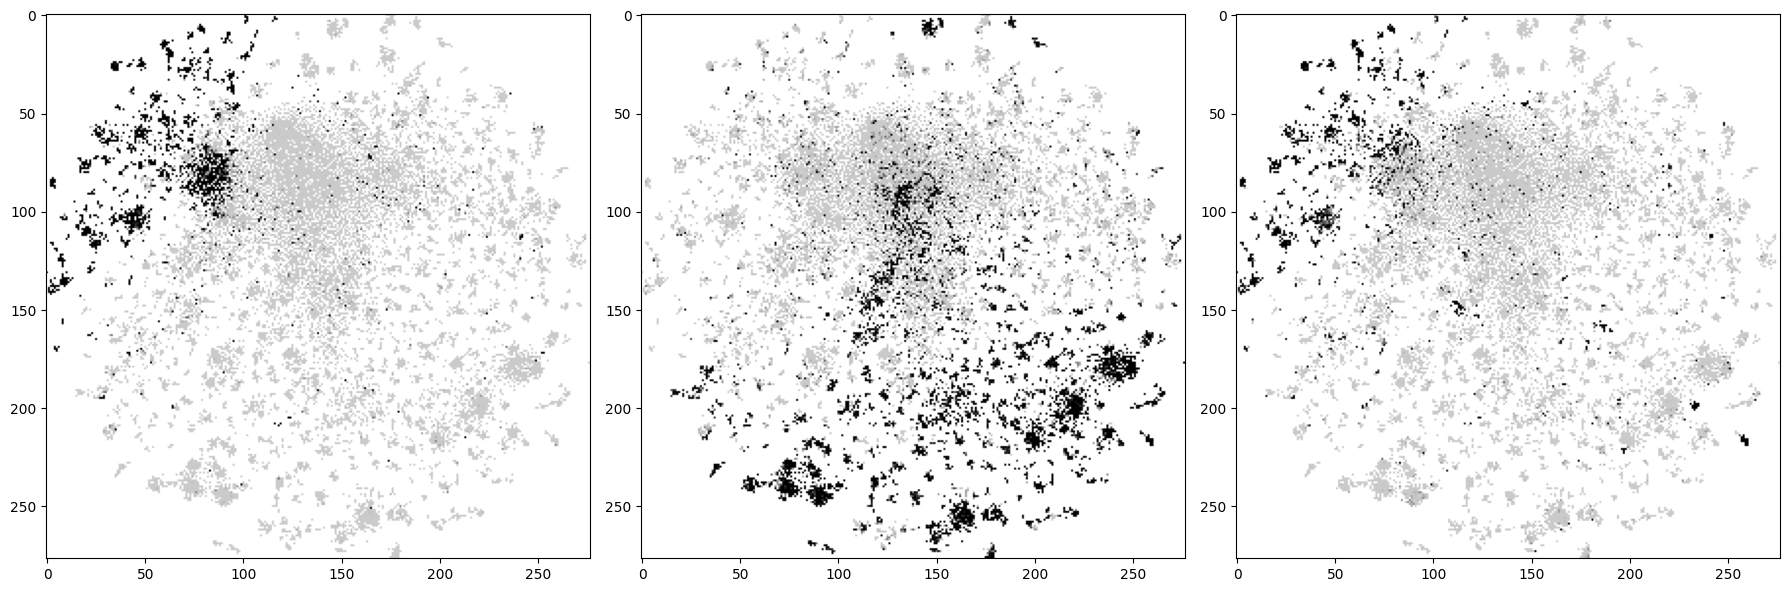

In [21]:
fig, ax = plt.subplots(1, 3, figsize=(18, 6))
for i in range(0,3):
    ax[i].imshow(X_train_img[i])
    # ax[i].title.set_text(f"Train[{i}] - class '{y_train[i]}'")
plt.tight_layout()

Transforming the testing data is done the same as transforming the 
training data.

In [ ]:
X_test_img = it.transform(X_test_norm, empty_value=1)

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
for i in range(0,3):
    ax[i].imshow(X_test_img[i])
    # ax[i].title.set_text(f"Test[{i}] - class '{y_test[i]}'")
plt.tight_layout()

## SqueezeNet

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.optim as optim

from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay

import warnings; 
warnings.simplefilter('ignore')

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

Modify [PyTrorch SqueezeNet 1.1][1] output to number of classes

[1]: https://pytorch.org/vision/stable/models/squeezenet.html

In [ ]:
model = torchvision.models.squeezenet1_1(weights='DEFAULT')
model.classifier.append(nn.Flatten())
_ = model.classifier.append(nn.Linear(1000, num_classes))

Transform numpy image format to PyTorch tensor. Using an untrained network,
so normalization as specificed in SqueezeNet documentation is not 
required.


In [ ]:
preprocess = transforms.Compose([
    transforms.ToTensor()
])

In [ ]:
X_train_tensor = torch.stack([preprocess(img) for img in X_train_img]).float()
y_train_tensor = torch.from_numpy(le.fit_transform(y_train))

X_test_tensor = torch.stack([preprocess(img) for img in X_test_img]).float()
y_test_tensor = torch.from_numpy(le.transform(y_test))

Generate pyTorch datasets and dataloaders for training and testing sets.

In [ ]:
batch_size = 200

trainset = TensorDataset(X_train_tensor, y_train_tensor)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)

testset = TensorDataset(X_test_tensor, y_test_tensor)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False)

Specify loss function and optimization algorithm

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(
    model.parameters(),
    lr=1e-04,
    #momentum=0.8,
    weight_decay=1e-05
)

Train SqueezeNet for 120 epochs

In [ ]:
model.train()
model.to(device)
for epoch in range(120):

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    # print epoch statistics
    if not (epoch % 20):
        print(f'[{epoch}] loss: {running_loss / len(X_train_tensor) * batch_size:.3f}')
print(f'[{epoch}] loss: {running_loss / len(X_train_tensor) * batch_size:.3f}')

Calculate accuracy of prediction

In [ ]:
model.to('cpu')
model = model.eval()

In [ ]:
with torch.no_grad():
    y_hat = model(X_train_tensor)
train_predicted = torch.max(y_hat, 1)[1]

In [ ]:
with torch.no_grad():
    y_hat = model(X_test_tensor)
test_predicted = torch.max(y_hat, 1)[1]

In [ ]:
print(f"The train accuracy was {accuracy_score(train_predicted, y_train_tensor):.3f}")
print(f"The test accuracy was {accuracy_score(test_predicted, y_test_tensor):.3f}")

In [ ]:
_ = ConfusionMatrixDisplay.from_predictions(test_predicted, y_test_tensor, display_labels=le.classes_)